In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

import os
import warnings; warnings.filterwarnings('ignore')


### Данные




В архиве собраны данные о туристическом трафике абонентов МФ в некоторые
небольшие города РФ.
Задача: нужно определить, в каких городах нам наиболее уместно развивать сеть
(устанавливать новые БС или оптимизировать работу существующих).
Набор данных ограничен. Но на основе его исследования нужно сгенерировать гипотезы и
подкрепить данными.

Переменные:
Column_1 - лишнее, не анализировать
Snap_date - дата начала месяца туризма
Id_hash - id абонента. Один абонент может встречаться несколько раз в разных месяцах
или городах
days - продолжительность присутствия в днях в точке туризма
home_region - номер домашнего региона
city - точка туризма
gender - предсказанный моделью пол абонента
age - предсказанный моделью возраст абонента в годах
mou - голосовой трафик абонента за месяц (snap_date) в минутах
mou_out - исходящий голосовой трафик абонента за месяц в минутах
dou - интернет-трфик абонента за месяц, МБ
Interests - список интересов абонента за месяц snap_date
top_service - url, по которому у абонента больше всего трафика за месяц
volume_sum - трафик абонента за время присутствия в точке туризма, МБ
dl/ul_volume_sum - разложение volume_sum на uplink, downlink, МБ

####  отдельные данные по одному городу
Попробуем посмотреть отдельно данные по одному городу


In [2]:
data = pd.read_csv('D:/data/test_case1/DA_кейс/Данные_2021/Tourists_Абинск_2021.csv', sep=',')
data.drop('Unnamed: 0', axis=1, inplace=True)
data

,snap_date,id_hash,days,home_region,tourists_region,city,gender,age,mou,mou_out,dou
0,2021.07.01,61fc25d86364a6a5d6e85319bcf7aef5,3,77,23,Абинск,1,47,33.512500,NaN,8.053427
1,2021.07.01,c42fc8d3ad95a2e006567967814463a3,15,61,23,Абинск,2,28,1738.257600,1029.315000,46874.117000
2,2021.07.01,ce99dc79821948d73c0d2ab2d9eee25d,5,34,23,Абинск,1,36,326.655000,173.512500,31097.098000
3,2021.07.01,02db2c7539fb8a552f48b42e3096151f,11,72,23,Абинск,2,34,165.549990,39.917496,2390.938200
4,2021.07.01,d3fd4dd683cf977fabbf8804d4006dfe,1,7,23,Абинск,2,33,1355.112500,469.910000,600.361100
...,...,...,...,...,...,...,...,...,...,...,...
55043,2021.12.01,483bd8549e39af74c3104ae3e7ea3afa,1,46,23,Абинск,1,33,250.092500,95.095000,18045.334000
55044,2021.12.01,767acc39d873b28e7d4da771b88546a0,12,61,23,Абинск,2,48,9.135000,NaN,NaN
55045,2021.12.01,767acc39d873b28e7d4da771b88546a0,12,61,23,Абинск,2,48,9.135000,NaN,NaN
55046,2021.12.01,c1f6ee796f3b7ab96501d34947d3bf4e,7,71,23,Абинск,1,25,15.819999,4.357500,47604.055000


Заполним пропуски медианными значениями, сначала группируем как можно больше признаков, чтобы медианное значение было наиболее характерным. Затем уменьшаем количество параметров группировки, чтобы заполнить оставшиеся пустые значения медианным значением более обобщенной группы 

In [3]:
# Список группируемых столбцов
group_columns_list = [['days', 'city', 'age', 'gender'],
                      ['city', 'age', 'gender'],
                      ['city']]

# Итерация по различным комбинациям группируемых столбцов
for group_cols in group_columns_list:
    data['mou'] = data.groupby(group_cols)['mou'].transform(lambda x: x.fillna(x.median()))
    data['mou_out'] = data.groupby(group_cols)['mou_out'].transform(lambda x: x.fillna(x.median()))
    data['dou'] = data.groupby(group_cols)['dou'].transform(lambda x: x.fillna(x.median()))

data

,snap_date,id_hash,days,home_region,tourists_region,city,gender,age,mou,mou_out,dou
0,2021.07.01,61fc25d86364a6a5d6e85319bcf7aef5,3,77,23,Абинск,1,47,33.512500,227.430000,8.053427
1,2021.07.01,c42fc8d3ad95a2e006567967814463a3,15,61,23,Абинск,2,28,1738.257600,1029.315000,46874.117000
2,2021.07.01,ce99dc79821948d73c0d2ab2d9eee25d,5,34,23,Абинск,1,36,326.655000,173.512500,31097.098000
3,2021.07.01,02db2c7539fb8a552f48b42e3096151f,11,72,23,Абинск,2,34,165.549990,39.917496,2390.938200
4,2021.07.01,d3fd4dd683cf977fabbf8804d4006dfe,1,7,23,Абинск,2,33,1355.112500,469.910000,600.361100
...,...,...,...,...,...,...,...,...,...,...,...
55043,2021.12.01,483bd8549e39af74c3104ae3e7ea3afa,1,46,23,Абинск,1,33,250.092500,95.095000,18045.334000
55044,2021.12.01,767acc39d873b28e7d4da771b88546a0,12,61,23,Абинск,2,48,9.135000,152.477505,1987.270100
55045,2021.12.01,767acc39d873b28e7d4da771b88546a0,12,61,23,Абинск,2,48,9.135000,152.477505,1987.270100
55046,2021.12.01,c1f6ee796f3b7ab96501d34947d3bf4e,7,71,23,Абинск,1,25,15.819999,4.357500,47604.055000


Преобразуем формат даты 

In [4]:
# Преобразование столбца 'date' в формат даты
data['date'] = pd.to_datetime(data['snap_date'])
data.drop('snap_date', axis=1, inplace=True)


# Создание новых столбцов с годом, месяцем и днем
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day

In [5]:
data

,id_hash,days,home_region,tourists_region,city,gender,age,mou,mou_out,dou,date,year,month,day
0,61fc25d86364a6a5d6e85319bcf7aef5,3,77,23,Абинск,1,47,33.512500,227.430000,8.053427,2021-07-01,2021,7,1
1,c42fc8d3ad95a2e006567967814463a3,15,61,23,Абинск,2,28,1738.257600,1029.315000,46874.117000,2021-07-01,2021,7,1
2,ce99dc79821948d73c0d2ab2d9eee25d,5,34,23,Абинск,1,36,326.655000,173.512500,31097.098000,2021-07-01,2021,7,1
3,02db2c7539fb8a552f48b42e3096151f,11,72,23,Абинск,2,34,165.549990,39.917496,2390.938200,2021-07-01,2021,7,1
4,d3fd4dd683cf977fabbf8804d4006dfe,1,7,23,Абинск,2,33,1355.112500,469.910000,600.361100,2021-07-01,2021,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55043,483bd8549e39af74c3104ae3e7ea3afa,1,46,23,Абинск,1,33,250.092500,95.095000,18045.334000,2021-12-01,2021,12,1
55044,767acc39d873b28e7d4da771b88546a0,12,61,23,Абинск,2,48,9.135000,152.477505,1987.270100,2021-12-01,2021,12,1
55045,767acc39d873b28e7d4da771b88546a0,12,61,23,Абинск,2,48,9.135000,152.477505,1987.270100,2021-12-01,2021,12,1
55046,c1f6ee796f3b7ab96501d34947d3bf4e,7,71,23,Абинск,1,25,15.819999,4.357500,47604.055000,2021-12-01,2021,12,1


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55048 entries, 0 to 55047
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id_hash          55048 non-null  object        
 1   days             55048 non-null  int64         
 2   home_region      55048 non-null  int64         
 3   tourists_region  55048 non-null  int64         
 4   city             55048 non-null  object        
 5   gender           55048 non-null  int64         
 6   age              55048 non-null  int64         
 7   mou              55048 non-null  float64       
 8   mou_out          55048 non-null  float64       
 9   dou              55048 non-null  float64       
 10  date             55048 non-null  datetime64[ns]
 11  year             55048 non-null  int32         
 12  month            55048 non-null  int32         
 13  day              55048 non-null  int32         
dtypes: datetime64[ns](1), float64(3), int3

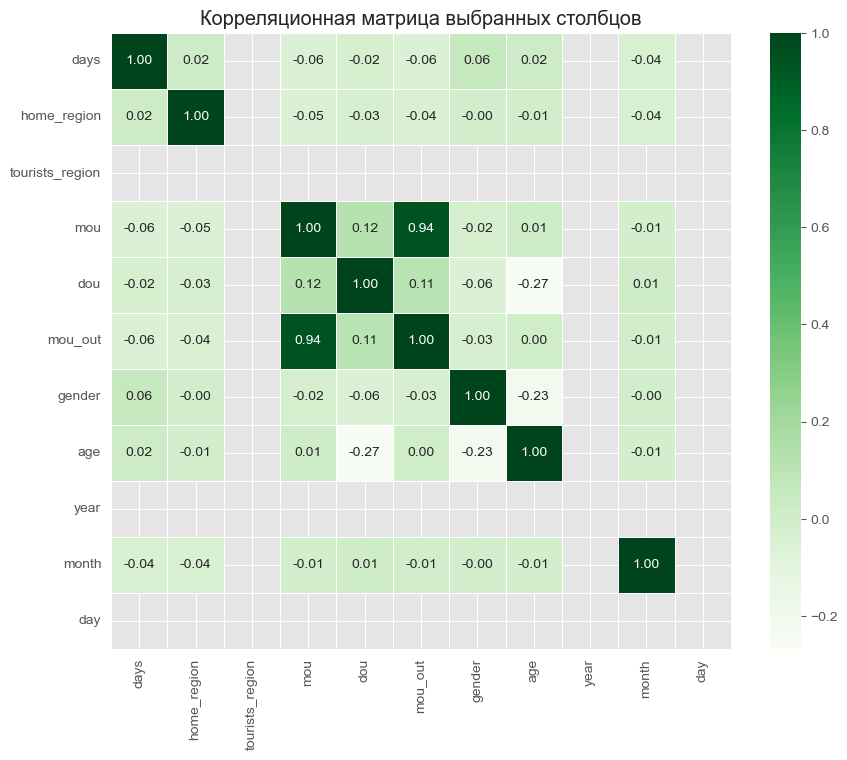

In [7]:
selected_columns = ['days', 'home_region', 'tourists_region', 'mou', 'dou', 'mou_out', 'gender', 'age',
                    'year','month', 'day']


# Создание подмножества датафрейма только с выбранными столбцами
selected_dataframe = data[selected_columns]

# Вычисление корреляционной матрицы для подмножества столбцов
corr_matrix_df = selected_dataframe.corr()

# Построение тепловой карты
plt.style.use('ggplot')
plt.figure(figsize=(10, 8))  # Регулирование размера фигуры
sns.heatmap(corr_matrix_df, annot=True, cmap="Greens", fmt=".2f", linewidths=.5)
plt.title('Корреляционная матрица выбранных столбцов')
plt.show()

Построили корреляционную матрицу, по ней можем сказать что данные не коррелируют вообще (черные столбцы - вообще отсутствует корреляция).
MOU и MOU_OUT - логично что коррелируют по определению данных.
Важно отметить, что согласно данной матрице корреляции у нас трафик интернета абонента и количество минут не коррелируют, поэтому предполагаю что надо будет проверить на максимумы и голосовой трафик и интернет трафик

In [8]:
# for column in data.columns:
#     plt.figure(figsize=(8, 6))
#     sns.histplot(data[column], kde=True)
#     plt.title(f'Distribution of {column}')
#     plt.xlabel(column)
#     plt.ylabel('Frequency')
#     plt.show()

Итак, наша задача: нужно определить, в каких городах нам наиболее уместно развивать сеть (устанавливать новые БС или оптимизировать работу существующих).

Планирование сетей - задача на которую влияют многие факторы, но мы предполагаем, что основной - количество трафика в первую очередь. (Traffic Models: User traffic distribution is a main factor that ultimately determines the cellular system plan and, hence, is a key input in the CP process (https://ieeexplore.ieee.org/abstract/document/7883847) 

Поэтому предполагаем что надо посмотреть медианное значение по городам, и построить графики.

### Загрузим данные за 2021 год

In [9]:
#считаем данные в датафрейм
def read_csv_files_into_dataframe(folder_path):
    # Получаем список всех файлов в указанной папке
    file_list = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.csv')]

    # Создаем пустой DataFrame
    combined_df = pd.DataFrame()

    # Читаем каждый CSV файл и добавляем его в единый DataFrame
    for file in file_list:
        df = pd.read_csv(file)
        combined_df = pd.concat([combined_df, df], ignore_index=True)

    return combined_df

folder_path = "D:/data/test_case1/DA_кейс/Данные_2021/"
combined_dataframe = read_csv_files_into_dataframe(folder_path)

# Выводим общее количество строк и столбцов в объединенном датасете
print("Total Rows:", len(combined_dataframe))
print("Total Columns:", len(combined_dataframe.columns))



Total Rows: 3884691
Total Columns: 12


In [10]:
combined_dataframe.drop('Unnamed: 0', axis=1, inplace=True)

In [11]:
# Преобразование столбца 'date' в формат даты
combined_dataframe['date'] = pd.to_datetime(combined_dataframe['snap_date'])
combined_dataframe.drop('snap_date', axis=1, inplace=True)


# Создание новых столбцов с годом, месяцем и днем
combined_dataframe['year'] = combined_dataframe['date'].dt.year
combined_dataframe['month'] = combined_dataframe['date'].dt.month
combined_dataframe['day'] = combined_dataframe['date'].dt.day

In [12]:
# заполним пропуски медианными значениями по группе
# Список группируемых столбцов
group_columns_list = [['days', 'city', 'age', 'gender'],
                      ['city', 'age', 'gender'],
                      ['city']]

# Итерация по различным комбинациям группируемых столбцов
for group_cols in group_columns_list:
    combined_dataframe['mou'] = combined_dataframe.groupby(group_cols)['mou'].transform(lambda x: x.fillna(x.median()))
    combined_dataframe['mou_out'] = combined_dataframe.groupby(group_cols)['mou_out'].transform(lambda x: x.fillna(x.median()))
    combined_dataframe['dou'] = combined_dataframe.groupby(group_cols)['dou'].transform(lambda x: x.fillna(x.median()))

In [13]:
combined_dataframe

,id_hash,days,home_region,tourists_region,city,gender,age,mou,mou_out,dou,date,year,month,day
0,61fc25d86364a6a5d6e85319bcf7aef5,3,77,23,Абинск,1,47,33.512500,227.430000,8.053427,2021-07-01,2021,7,1
1,c42fc8d3ad95a2e006567967814463a3,15,61,23,Абинск,2,28,1738.257600,1029.315000,46874.117000,2021-07-01,2021,7,1
2,ce99dc79821948d73c0d2ab2d9eee25d,5,34,23,Абинск,1,36,326.655000,173.512500,31097.098000,2021-07-01,2021,7,1
3,02db2c7539fb8a552f48b42e3096151f,11,72,23,Абинск,2,34,165.549990,39.917496,2390.938200,2021-07-01,2021,7,1
4,d3fd4dd683cf977fabbf8804d4006dfe,1,7,23,Абинск,2,33,1355.112500,469.910000,600.361100,2021-07-01,2021,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3884686,25dccf5be32c74bec32fd15045edff7d,8,37,33,Юрьев-Польский,1,23,70.857506,35.577500,6271.548300,2021-12-01,2021,12,1
3884687,ea926a74baad3680d371beca8d981c11,15,37,33,Юрьев-Польский,1,37,328.912500,85.295006,41689.750000,2021-12-01,2021,12,1
3884688,ea926a74baad3680d371beca8d981c11,15,37,33,Юрьев-Польский,1,37,328.912500,85.295006,41689.750000,2021-12-01,2021,12,1
3884689,c73a6b4d10fbd4cdab000c29b538793d,2,61,33,Юрьев-Польский,3,0,964.459960,462.315000,444.645260,2021-12-01,2021,12,1


In [14]:
combined_dataframe.drop('id_hash', axis=1, inplace=True)
combined_dataframe.drop('date', axis=1, inplace=True)
combined_dataframe.drop('day', axis=1, inplace=True)
combined_dataframe.drop('year', axis=1, inplace=True)


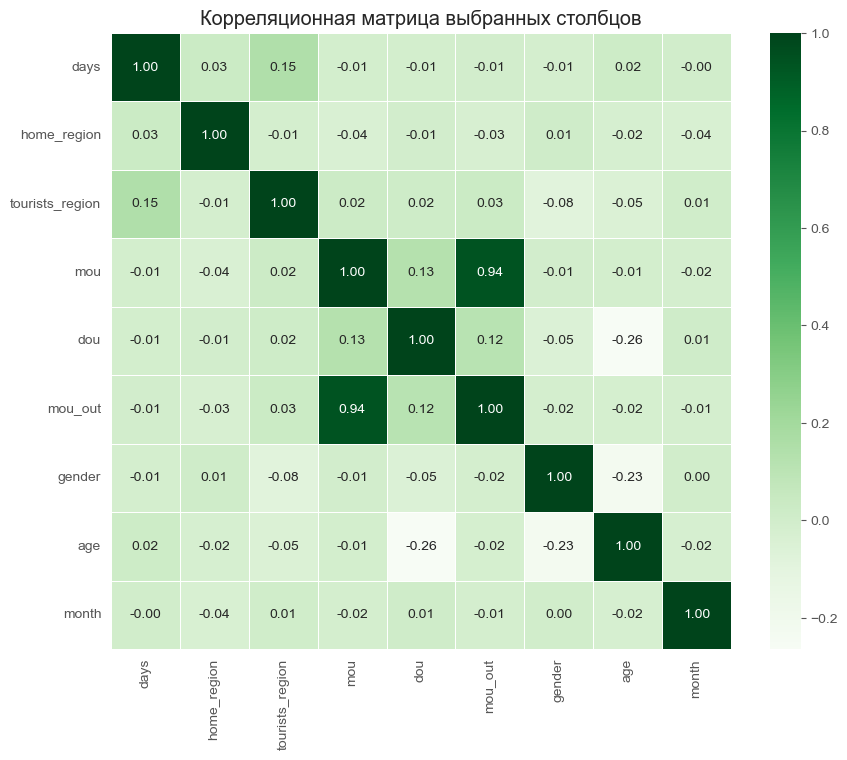

In [15]:
selected_columns = ['days', 'home_region', 'tourists_region', 'mou', 'dou', 'mou_out', 'gender', 'age',
                    'month']


# Создание подмножества датафрейма только с выбранными столбцами
selected_dataframe = combined_dataframe[selected_columns]

# Вычисление корреляционной матрицы для подмножества столбцов
corr_matrix_df = selected_dataframe.corr()

# Построение тепловой карты
plt.style.use('ggplot')
plt.figure(figsize=(10, 8))  # Регулирование размера фигуры
sns.heatmap(corr_matrix_df, annot=True, cmap="Greens", fmt=".2f", linewidths=.5)
plt.title('Корреляционная матрица выбранных столбцов')
plt.show()

In [16]:
combined_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3884691 entries, 0 to 3884690
Data columns (total 10 columns):
 #   Column           Dtype  
---  ------           -----  
 0   days             int64  
 1   home_region      int64  
 2   tourists_region  int64  
 3   city             object 
 4   gender           int64  
 5   age              int64  
 6   mou              float64
 7   mou_out          float64
 8   dou              float64
 9   month            int32  
dtypes: float64(3), int32(1), int64(5), object(1)
memory usage: 281.6+ MB


In [17]:
combined_dataframe.columns

Index(['days', 'home_region', 'tourists_region', 'city', 'gender', 'age',
       'mou', 'mou_out', 'dou', 'month'],
      dtype='object')

In [18]:
mou_median_by_city = combined_dataframe.groupby('city')['mou'].median()
mou_median_by_city


city
Абинск                318.185000
Александров           297.955000
Армавир               433.177500
Байкальск             312.961260
Белореченск           311.535000
Вязники               350.140000
Горно-Алтайск         292.372500
Городищи              274.242500
Гороховец             323.592500
Горячий Ключ          255.010010
Гулькевичи            441.148750
Ейск                  248.202500
Ковров                308.455000
Кольчугино            305.917500
Кореновск             350.122500
Кропоткин             377.002500
Крымск                273.472490
Курганинск            263.961250
Лабинск               341.232500
Лакинск               347.952480
Меленки               387.992500
Муром                 312.602500
Новокубанск           332.535000
Петушки               363.195000
Покров                339.832500
Сириус                317.362500
Славянск-на-Кубани    311.447500
Сортавала             284.873750
Струнино              310.371260
Темрюк                283.500000
Тимаш

In [19]:
# Сортировка медианных значений трафика mou 
mou_median_by_city_sorted = mou_median_by_city.sort_values()

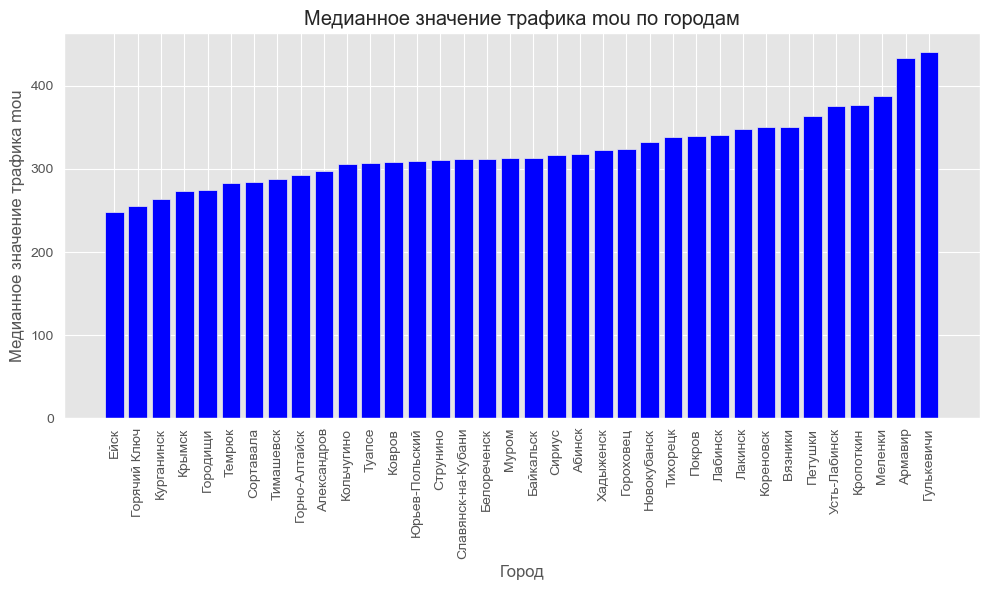

In [20]:
# Построение гистограммы для медианных значений трафика mou
plt.figure(figsize=(10, 6))
plt.bar(mou_median_by_city_sorted.index, mou_median_by_city_sorted.values, color='blue')
plt.xlabel('Город')
plt.ylabel('Медианное значение трафика mou')
plt.title('Медианное значение трафика mou по городам')
plt.xticks(rotation=90)  # Поворот меток по оси X для лучшей читаемости
plt.tight_layout()
plt.show()

In [21]:
dou_median_by_city = combined_dataframe.groupby('city')['dou'].median()
dou_median_by_city

city
Абинск                6257.31400
Александров           5899.06625
Армавир               8068.37840
Байкальск             6333.23000
Белореченск           5135.26440
Вязники               6952.26300
Горно-Алтайск         7917.46465
Городищи              5613.38800
Гороховец             5700.69200
Горячий Ключ          3845.83520
Гулькевичи            7891.37550
Ейск                  4668.79675
Ковров                6349.13000
Кольчугино            6201.71530
Кореновск             6758.79800
Кропоткин             6493.94140
Крымск                4760.30130
Курганинск            3951.69850
Лабинск               4997.81250
Лакинск               6986.37600
Меленки               6202.03015
Муром                 6204.01985
Новокубанск           4864.86700
Петушки               7657.23800
Покров                7101.31435
Сириус                6228.28300
Славянск-на-Кубани    5797.00395
Сортавала             5154.30150
Струнино              6135.45135
Темрюк                5042.25490
Тимаш

In [22]:
dou_median_by_city_sorted = dou_median_by_city.sort_values()


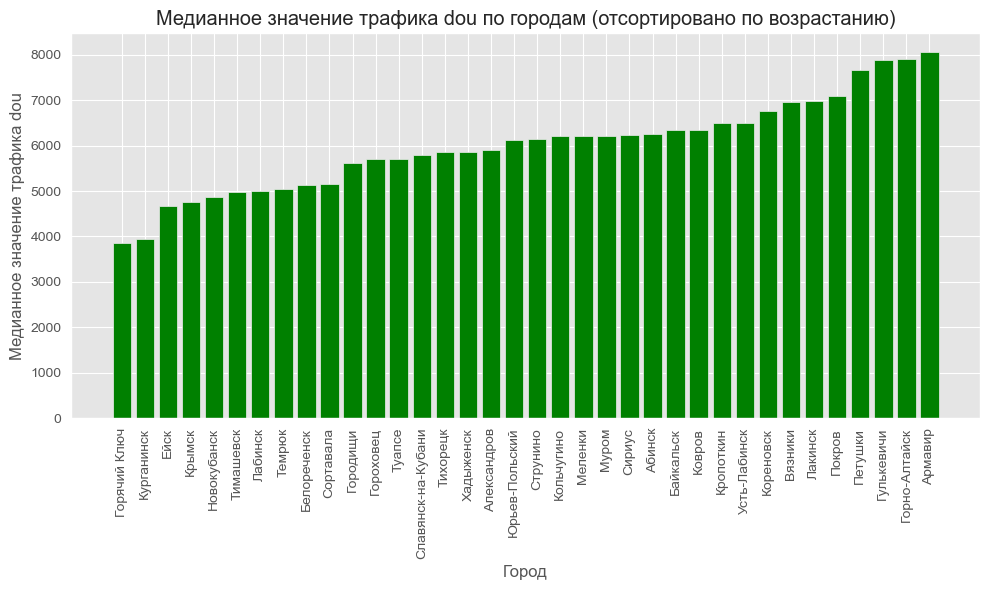

In [23]:
# Построение гистограммы для медианных значений трафика dou
plt.figure(figsize=(10, 6))
plt.bar(dou_median_by_city_sorted.index, dou_median_by_city_sorted.values, color='green')
plt.xlabel('Город')
plt.ylabel('Медианное значение трафика dou')
plt.title('Медианное значение трафика dou по городам (отсортировано по возрастанию)')
plt.xticks(rotation=90)  # Поворот меток по оси X для лучшей читаемости
plt.tight_layout()
plt.show()

У нас есть отсортированные гистограммы с трафиком звонков и с интернет траффиком.
Причем судя по гистограмме трафика звонков у нас есть разрыв между первыми 2 городами - Армавир и Гулькевичи и остальными, а по гистограмме интернет трафика у нас явно выделяются первые 4 города, в которые Армавир и Гулькевичи входят. Поэтому выберем эти 4 города и посмотрим трафик по городам помесячно

In [24]:
chosen_cities = dou_median_by_city_sorted[-4:].index.tolist()
chosen_cities

['Петушки', 'Гулькевичи', 'Горно-Алтайск', 'Армавир']

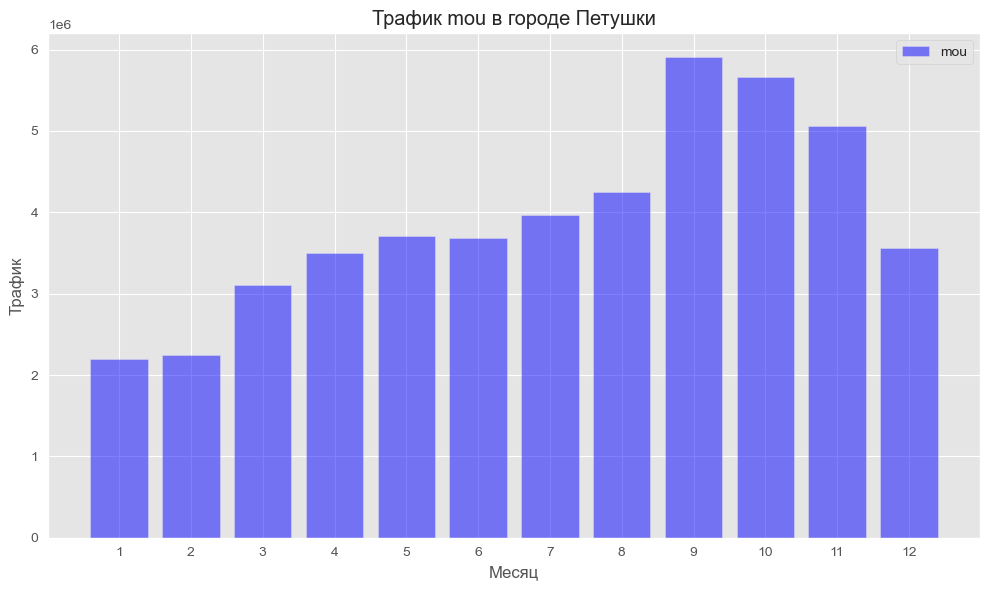

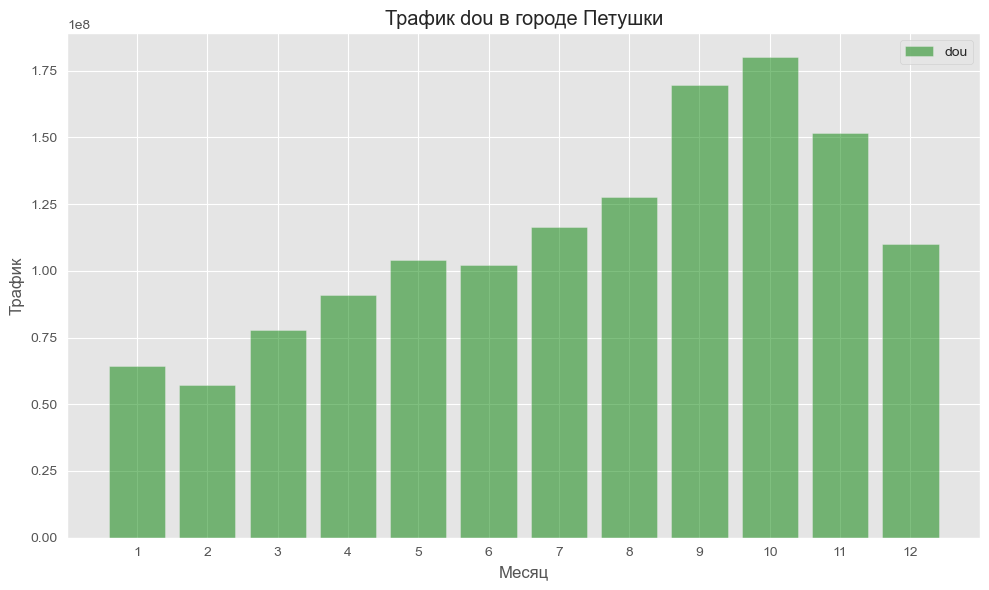

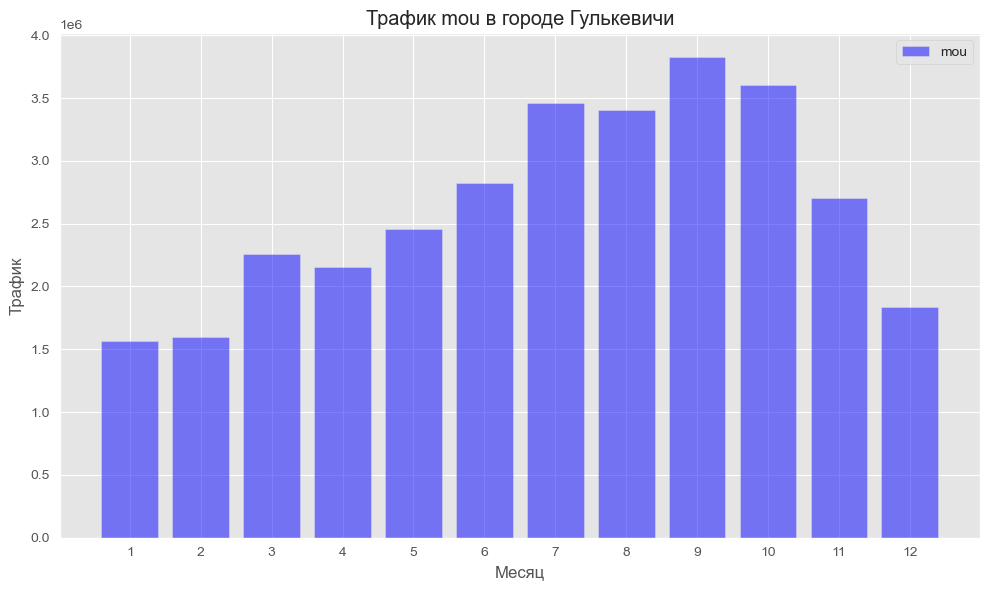

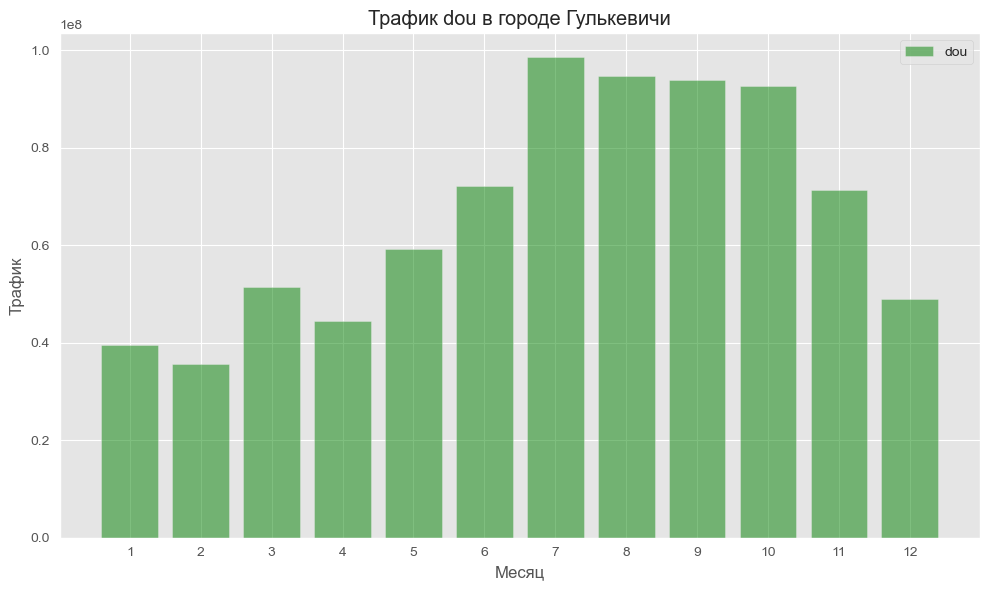

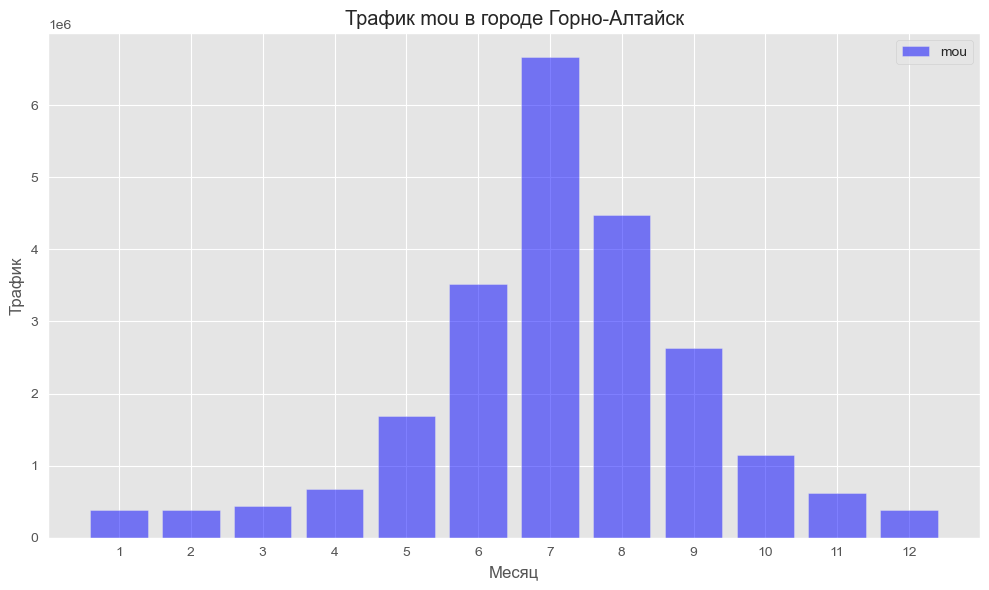

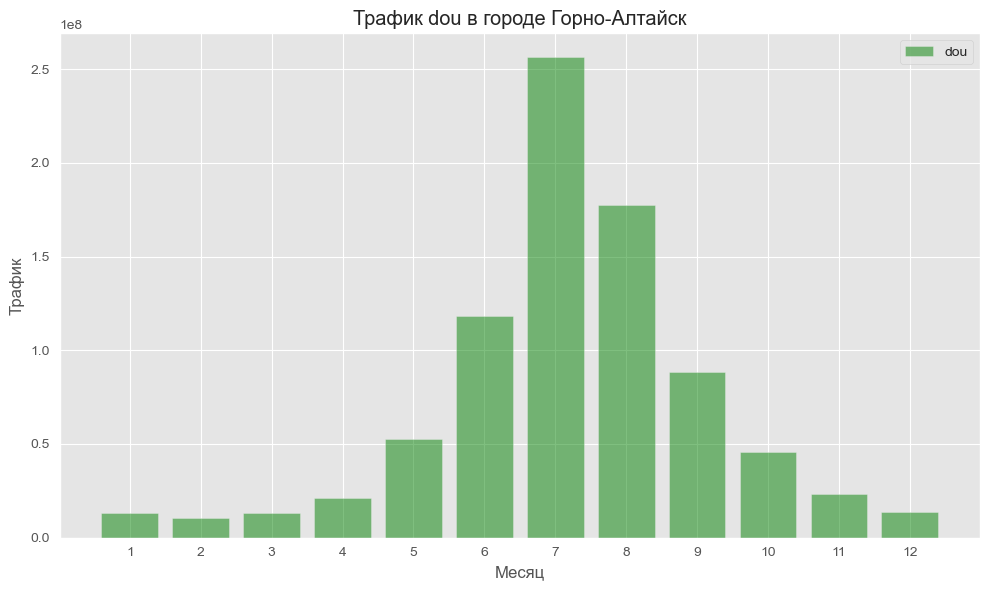

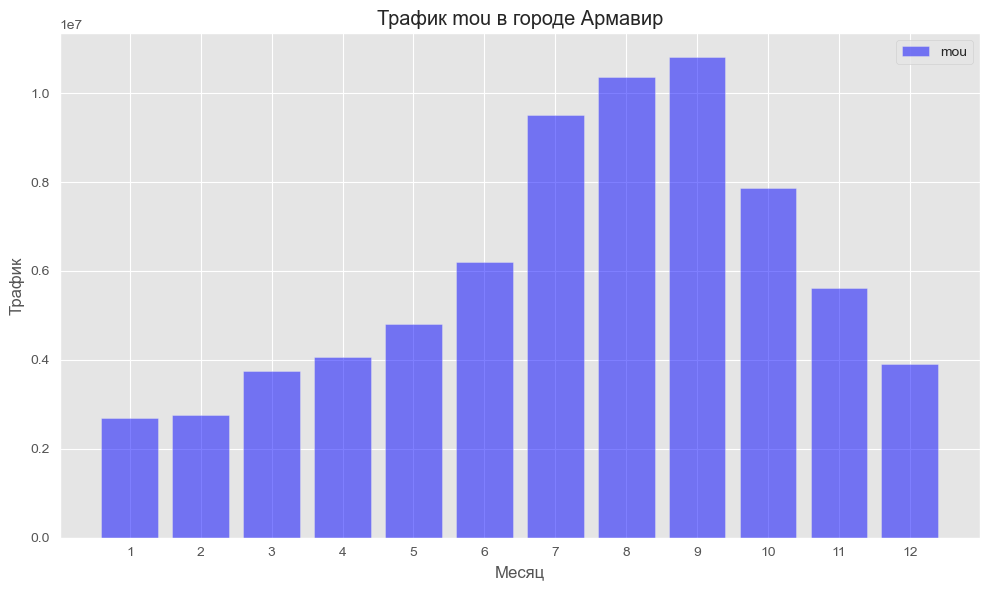

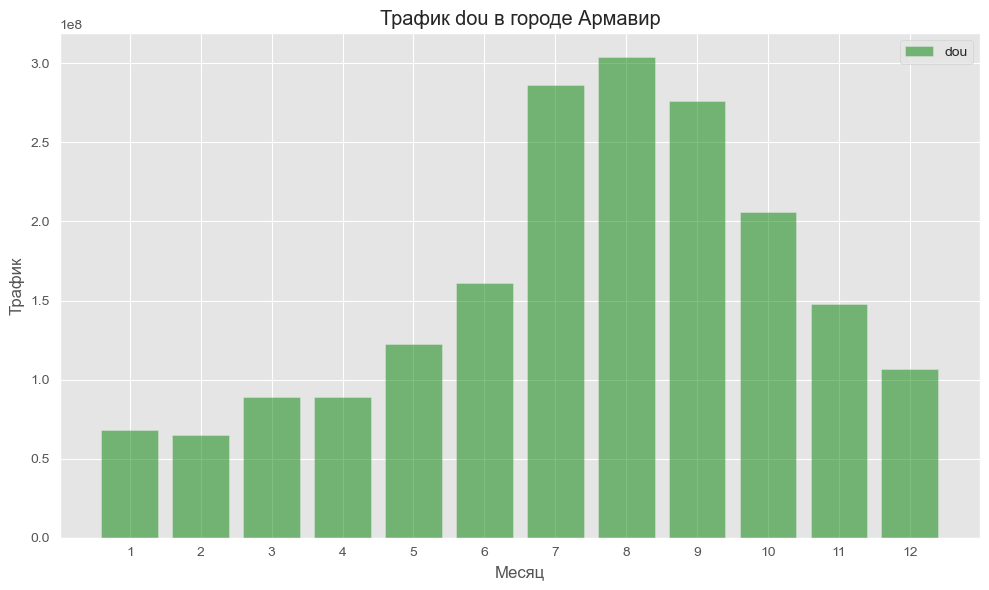

In [25]:
# Фильтруем исходный DataFrame по выбранным городам
chosen_cities_df = combined_dataframe[combined_dataframe['city'].isin(chosen_cities)]

# Группируем данные по городу и месяцу для трафика mou
mou_grouped = chosen_cities_df.groupby(['city', 'month'])['mou'].sum().reset_index()

# Группируем данные по городу и месяцу для трафика dou
dou_grouped = chosen_cities_df.groupby(['city', 'month'])['dou'].sum().reset_index()

# Строим отдельные графики для каждого города
for city in chosen_cities:
    city_mou = mou_grouped[mou_grouped['city'] == city]
    city_dou = dou_grouped[dou_grouped['city'] == city]

    plt.figure(figsize=(10, 6))

    # Строим гистограмму для трафика mou
    plt.bar(city_mou['month'], city_mou['mou'], color='blue', alpha=0.5, label='mou')

    plt.xlabel('Месяц')
    plt.ylabel('Трафик')
    plt.title(f'Трафик mou в городе {city}')

    plt.xticks(city_mou['month'])  # Устанавливаем метки на оси X для каждого месяца

    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))

    # Строим гистограмму для трафика dou
    plt.bar(city_dou['month'], city_dou['dou'], color='green', alpha=0.5, label='dou')

    plt.xlabel('Месяц')
    plt.ylabel('Трафик')
    plt.title(f'Трафик dou в городе {city}')

    plt.xticks(city_dou['month'])  # Устанавливаем метки на оси X для каждого месяца

    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

### теперь загрузим данные за 2022 год
Рассмотрим данные за 22 год, сделав акцент на 4 ранее отмеченных городах:
Петушки
Гулькевичи
Армавир
Горно-Алтайск

In [26]:
folder_path = "D:/data/test_case1/DA_кейс/Данные_2022/"
combined_dataframe_2 = read_csv_files_into_dataframe(folder_path)

# Выводим общее количество строк и столбцов в объединенном датасете
print("Total Rows:", len(combined_dataframe_2))
print("Total Columns:", len(combined_dataframe_2.columns))


Total Rows: 3818880
Total Columns: 17


In [27]:
combined_dataframe_2.drop('Unnamed: 0', axis=1, inplace=True)
combined_dataframe_2.drop('id_hash', axis=1, inplace=True)

# Преобразование столбца 'date' в формат даты
combined_dataframe_2['date'] = pd.to_datetime(combined_dataframe_2['snap_date'])
combined_dataframe_2.drop('snap_date', axis=1, inplace=True)

# Создание новых столбцов с годом, месяцем и днем
combined_dataframe_2['year'] = combined_dataframe_2['date'].dt.year
combined_dataframe_2['month'] = combined_dataframe_2['date'].dt.month
combined_dataframe_2['day'] = combined_dataframe_2['date'].dt.day
# заполним пропуски медианными значениями по группе
# Список группируемых столбцов
group_columns_list = [['days', 'city', 'age', 'gender'],
                      ['city', 'age', 'gender'],
                      ['city']]

# Итерация по различным комбинациям группируемых столбцов
for group_cols in group_columns_list:
    combined_dataframe_2['mou'] = combined_dataframe_2.groupby(group_cols)['mou'].transform(lambda x: x.fillna(x.median()))
    combined_dataframe_2['mou_out'] = combined_dataframe_2.groupby(group_cols)['mou_out'].transform(
        lambda x: x.fillna(x.median()))
    combined_dataframe_2['dou'] = combined_dataframe_2.groupby(group_cols)['dou'].transform(lambda x: x.fillna(x.median()))

In [28]:
combined_dataframe_2

,days,home_region,tourists_region,city,gender,age,mou,mou_out,dou,interests,top_service,volume_sum,dl_volume_sum,ul_volume_sum,date,year,month,day
0,7,9,23,Абинск,2,51,494.322480,298.847500,7932.82470,"[Контент на тему путешествий, Email-клиенты, П...",[existing],2.779278e+09,2.378326e+09,4.009526e+08,2022-08-01,2022,8,1
1,8,3,23,Абинск,2,31,329.349980,206.412490,2366.39140,"[Активный отдых, Контент на тему путешествий, ...",[unknowntcp],3.199224e+09,2.500532e+09,6.986923e+08,2022-08-01,2022,8,1
2,12,43,23,Абинск,1,48,334.232500,132.650010,2604.36820,"[Программное обеспечение, Активный отдых, Моби...",[dns],9.823515e+08,9.017218e+08,8.062974e+07,2022-08-01,2022,8,1
3,9,63,23,Абинск,2,40,171.045000,142.135010,1827.84390,"[Кулинария и рецепты, Новости и СМИ, Образован...",[youtube],5.062598e+08,4.584678e+08,4.779204e+07,2022-08-01,2022,8,1
4,7,61,23,Абинск,3,39,367.395000,224.630000,31482.02700,"[Навигация, Активный отдых, Мессенджеры и чаты...",[existing],4.833227e+10,4.569014e+10,2.642137e+09,2022-08-01,2022,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3818875,9,37,33,Юрьев-Польский,1,32,1503.110000,799.365000,7869.65040,"[Программное обеспечение, Фитнес, бег и здоров...",[dns],3.651156e+07,2.125558e+07,1.525598e+07,2022-12-01,2022,12,1
3818876,7,77,33,Юрьев-Польский,1,41,1500.380000,693.490000,10923.86700,"[Государственный информационный портал, Банки,...",[yandex],1.745375e+08,1.042098e+08,7.032774e+07,2022-12-01,2022,12,1
3818877,1,52,33,Юрьев-Польский,1,36,948.920000,705.635000,8897.45100,"[Навигация, Новости и СМИ, Боевые искусства]",[google],7.950318e+07,6.346635e+07,1.603684e+07,2022-12-01,2022,12,1
3818878,15,37,33,Юрьев-Польский,1,27,4.742499,4.742499,953.58044,"[Автозапчасти,автотовары, Общественный транспо...",[google],9.392589e+07,6.859338e+07,2.533251e+07,2022-12-01,2022,12,1


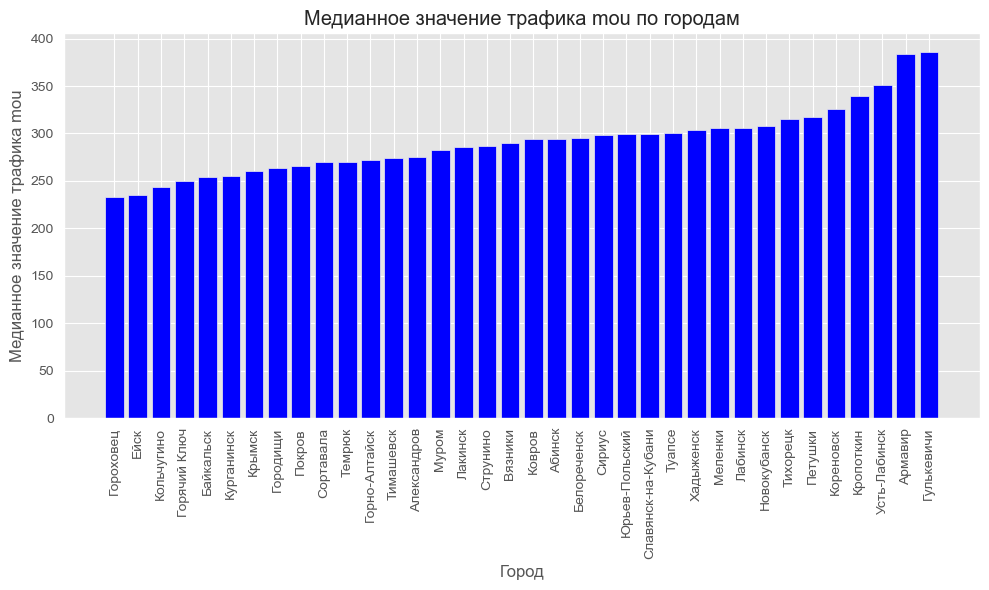

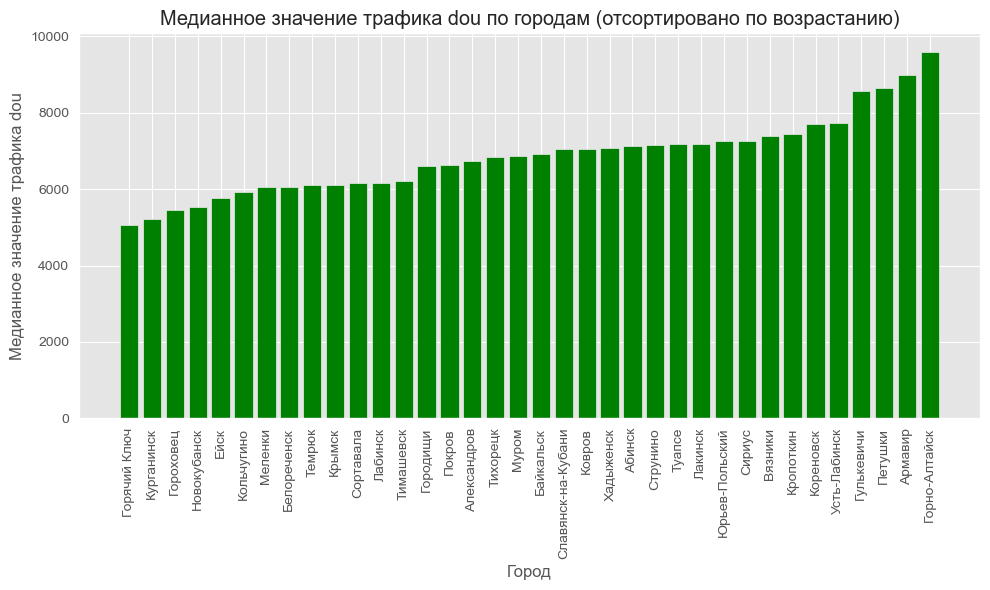

In [29]:
mou_median_by_city_2 = combined_dataframe_2.groupby('city')['mou'].median()


# Сортировка медианных значений трафика mou 
mou_median_by_city_sorted_2 = mou_median_by_city_2.sort_values()
# Построение гистограммы для медианных значений трафика mou
plt.figure(figsize=(10, 6))
plt.bar(mou_median_by_city_sorted_2.index, mou_median_by_city_sorted_2.values, color='blue')
plt.xlabel('Город')
plt.ylabel('Медианное значение трафика mou')
plt.title('Медианное значение трафика mou по городам')
plt.xticks(rotation=90)  # Поворот меток по оси X для лучшей читаемости
plt.tight_layout()
plt.show()

dou_median_by_city_2 = combined_dataframe_2.groupby('city')['dou'].median()
dou_median_by_city_sorted_2 = dou_median_by_city_2.sort_values()

# Построение гистограммы для медианных значений трафика dou
plt.figure(figsize=(10, 6))
plt.bar(dou_median_by_city_sorted_2.index, dou_median_by_city_sorted_2.values, color='green')
plt.xlabel('Город')
plt.ylabel('Медианное значение трафика dou')
plt.title('Медианное значение трафика dou по городам (отсортировано по возрастанию)')
plt.xticks(rotation=90)  # Поворот меток по оси X для лучшей читаемости
plt.tight_layout()
plt.show()

In [30]:
# Фильтруем исходный DataFrame по выбранным городам
chosen_cities_df_2 = combined_dataframe_2[combined_dataframe_2['city'].isin(chosen_cities)]

# Группируем данные по городу и месяцу для трафика mou для каждого года
mou_grouped_2021 = chosen_cities_df.groupby(['city', 'month'])['mou'].sum().reset_index()
mou_grouped_2022 = chosen_cities_df_2.groupby(['city', 'month'])['mou'].sum().reset_index()

# Группируем данные по городу и месяцу для трафика dou для каждого года
dou_grouped_2021 = chosen_cities_df.groupby(['city', 'month'])['dou'].sum().reset_index()
dou_grouped_2022 = chosen_cities_df_2.groupby(['city', 'month'])['dou'].sum().reset_index()


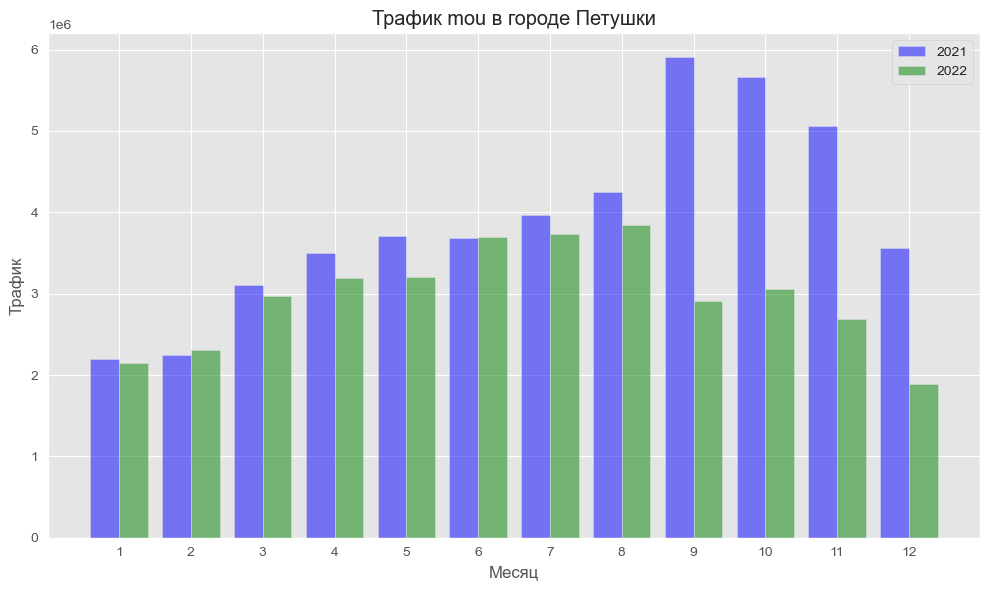

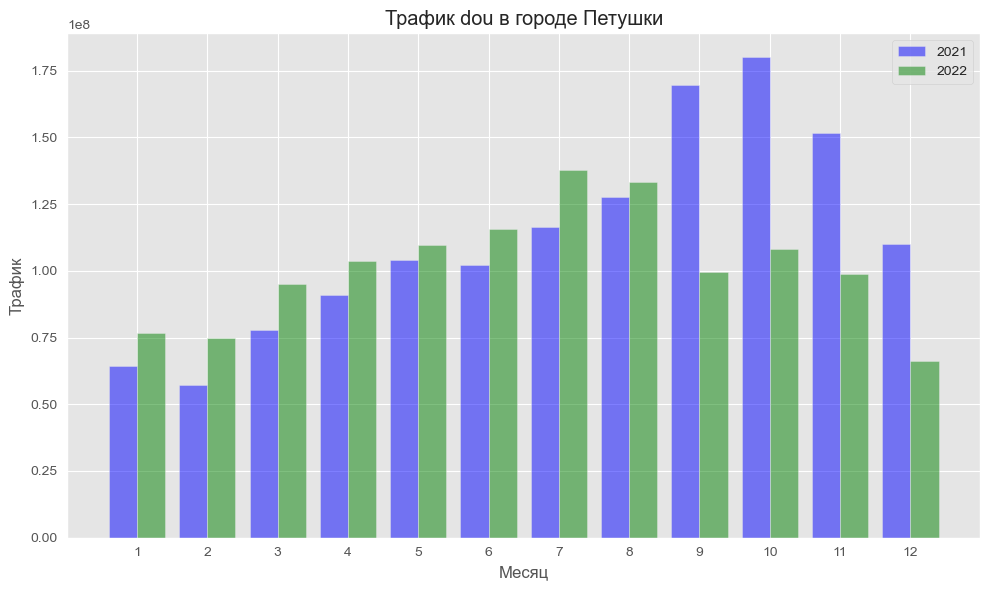

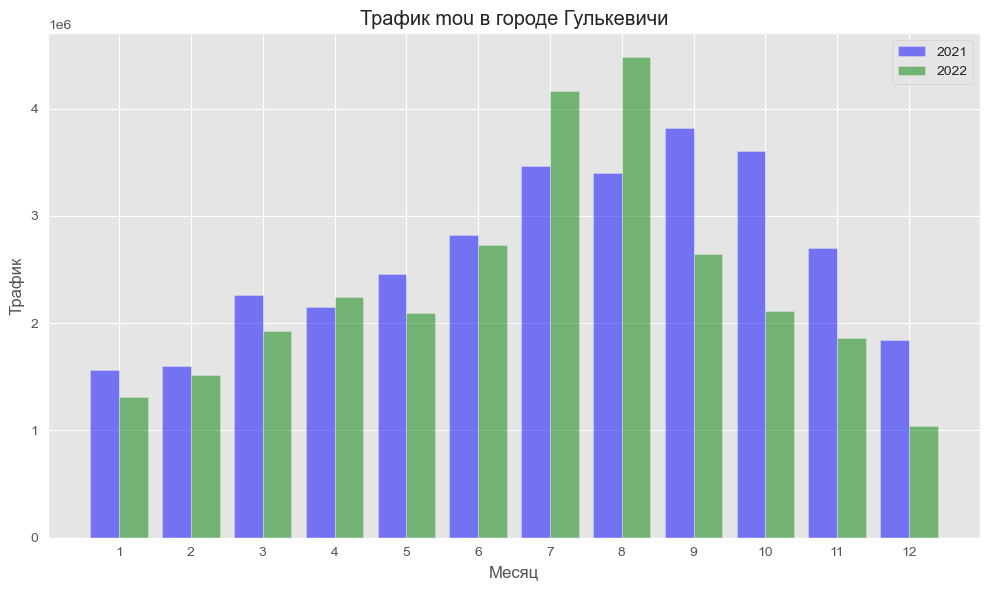

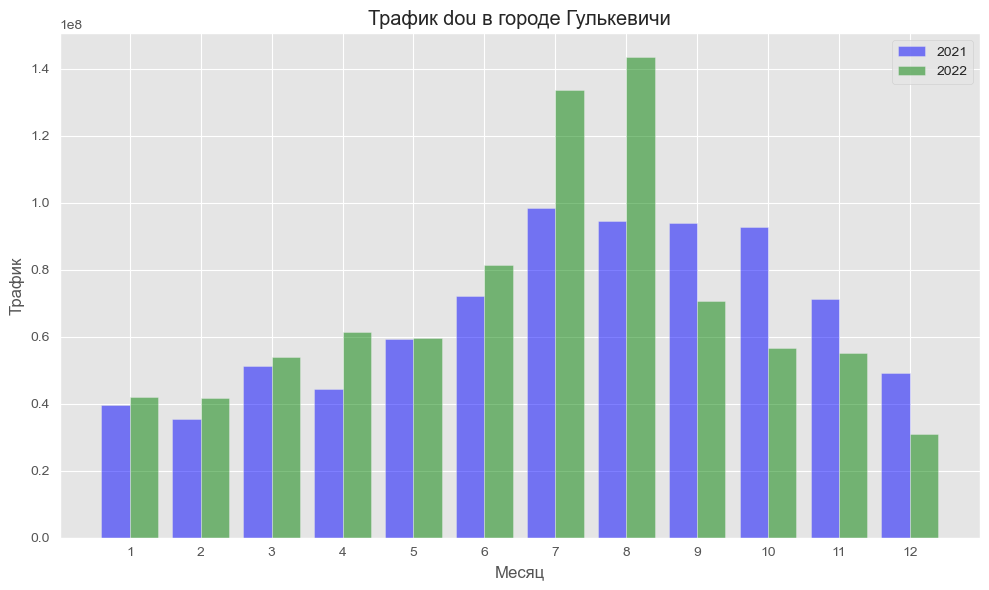

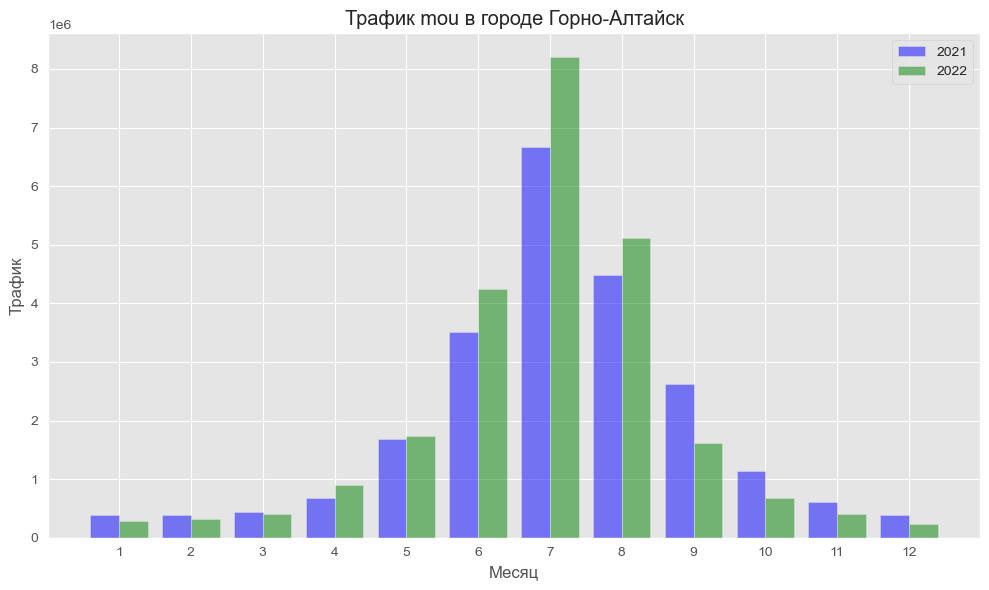

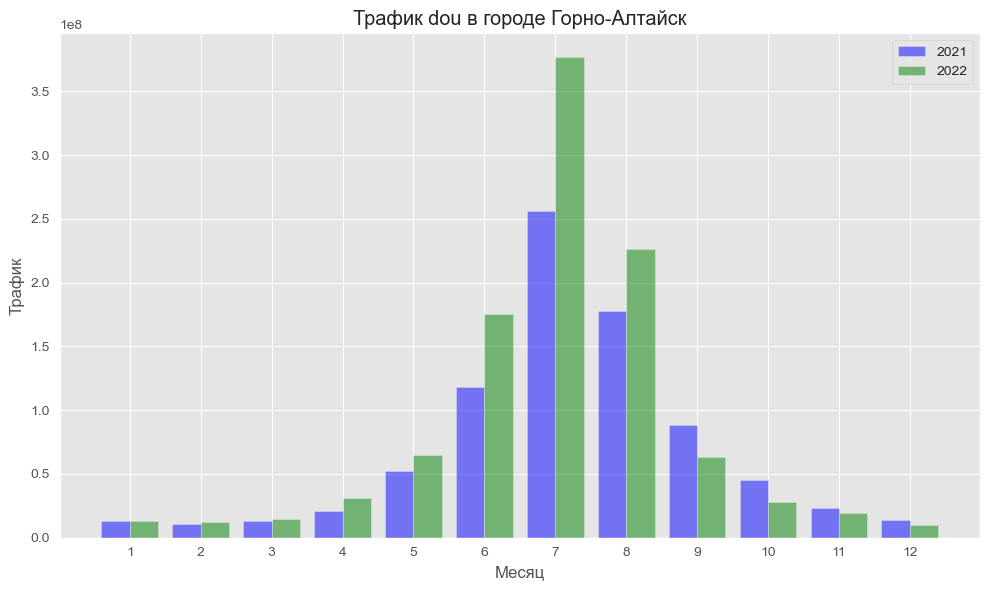

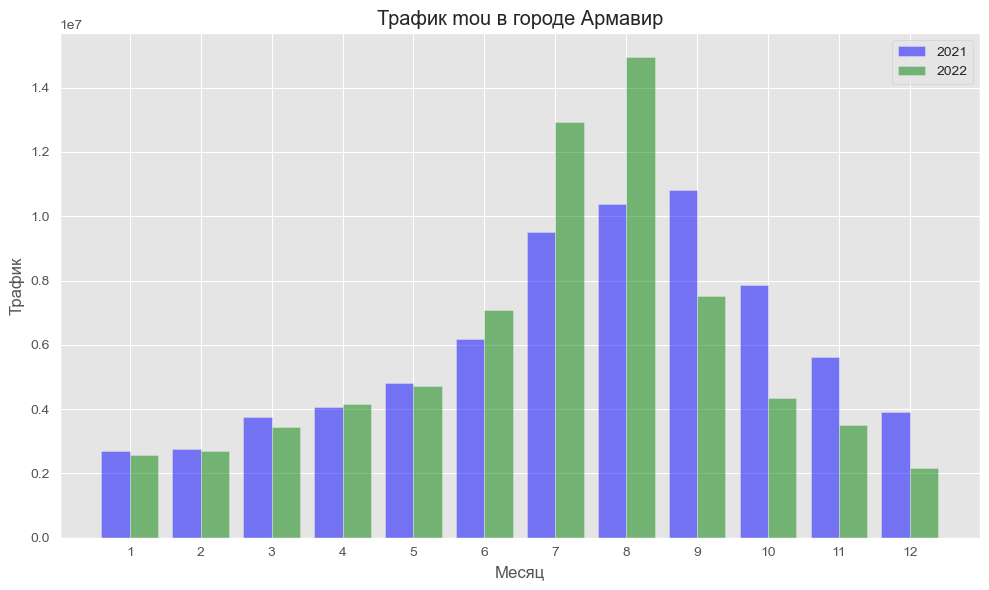

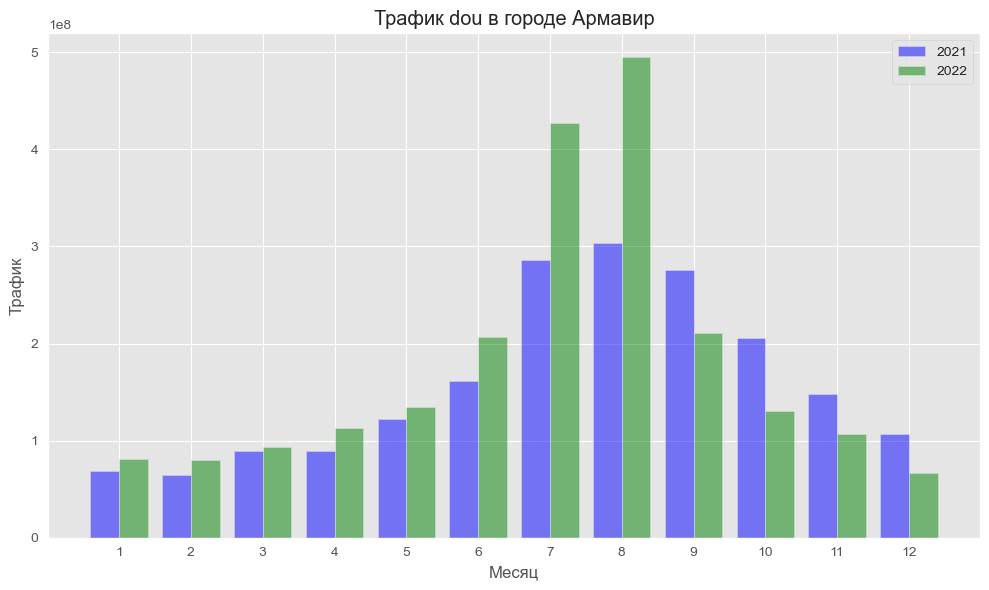

In [31]:
# Создаем массив для месяцев
months = np.arange(1, 13)

# Строим гистограммы для каждого города
for city in chosen_cities:
    # Фильтруем данные для текущего города и года
    city_mou_2021 = mou_grouped_2021[(mou_grouped_2021['city'] == city)]
    city_mou_2022 = mou_grouped_2022[(mou_grouped_2022['city'] == city)]

    city_dou_2021 = dou_grouped_2021[(dou_grouped_2021['city'] == city)]
    city_dou_2022 = dou_grouped_2022[(dou_grouped_2022['city'] == city)]

    # Создаем график для трафика mou
    plt.figure(figsize=(10, 6))
    plt.bar(city_mou_2021['month'] - 0.2, city_mou_2021['mou'], color='blue', alpha=0.5, width=0.4, label='2021')
    plt.bar(city_mou_2022['month'] + 0.2, city_mou_2022['mou'], color='green', alpha=0.5, width=0.4, label='2022')

    plt.xlabel('Месяц')
    plt.ylabel('Трафик')
    plt.title(f'Трафик mou в городе {city}')
    plt.xticks(months)  # Устанавливаем метки на оси X для каждого месяца
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Создаем график для трафика dou
    plt.figure(figsize=(10, 6))
    plt.bar(city_dou_2021['month'] - 0.2, city_dou_2021['dou'], color='blue', alpha=0.5, width=0.4, label='2021')
    plt.bar(city_dou_2022['month'] + 0.2, city_dou_2022['dou'], color='green', alpha=0.5, width=0.4, label='2022')

    plt.xlabel('Месяц')
    plt.ylabel('Трафик')
    plt.title(f'Трафик dou в городе {city}')
    plt.xticks(months)  # Устанавливаем метки на оси X для каждого месяца
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Итак, мы видим:
Петушки - спад трафика
Гулькевичи, Армавир, Горно-Алтайск - рост трафика. 

Логично было бы тогда исключить Петушки из списка приоритетного развития. У нас есть три номинанта, для них применим тест Манна-Уитни.

Тест Манна-Уитни позволяют сделать вывод о статистической значимости различий между данными за 2021 и 2022 годы для каждого города по трафику mou и dou.
Если значение p-value меньше выбранного уровня значимости (обычно 0.05), то мы можем отвергнуть нулевую гипотезу о том, что медианные значения двух выборок равны, и сделать вывод о наличии статистически значимых различий.

In [32]:

# Создаем список для хранения результатов теста Манна-Уитни для каждого города
mou_p_values = []
dou_p_values = []

# Применяем тест Манна-Уитни для каждого города отдельно
for city in chosen_cities:
    # Фильтруем данные для текущего города и года
    mou_2021 = chosen_cities_df[(chosen_cities_df['city'] == city)]['mou']
    mou_2022 = chosen_cities_df_2[(chosen_cities_df_2['city'] == city)]['mou']

    dou_2021 = chosen_cities_df[(chosen_cities_df['city'] == city)]['dou']
    dou_2022 = chosen_cities_df_2[(chosen_cities_df_2['city'] == city)]['dou']

    # Применяем тест Манна-Уитни
    statistic_mou, p_value_mou = mannwhitneyu(mou_2021, mou_2022)
    statistic_dou, p_value_dou = mannwhitneyu(dou_2021, dou_2022)

    mou_p_values.append(p_value_mou)
    dou_p_values.append(p_value_dou)

    # Выводим результаты теста для каждого города
    print(f"Тест Манна-Уитни для города {city} (mou): p-value = {p_value_mou}")
    print(f"Тест Манна-Уитни для города {city} (dou): p-value = {p_value_dou}")

    # Сравниваем средние значения p-value с уровнем значимости
    alpha = 0.05
    if p_value_mou < alpha:
        print("Существуют статистически значимые различия между данными за 2021 и 2022 годы по трафику mou.")
    else:
        print("Нет статистически значимых различий между данными за 2021 и 2022 годы по трафику mou.")
    
    if p_value_dou < alpha:
        print("Существуют статистически значимые различия между данными за 2021 и 2022 годы по трафику dou.")
    else:
        print("Нет статистически значимых различий между данными за 2021 и 2022 годы по трафику dou.")


Тест Манна-Уитни для города Петушки (mou): p-value = 3.7797700243669594e-52
Тест Манна-Уитни для города Петушки (dou): p-value = 2.841177902506792e-30
Существуют статистически значимые различия между данными за 2021 и 2022 годы по трафику mou.
Существуют статистически значимые различия между данными за 2021 и 2022 годы по трафику dou.
Тест Манна-Уитни для города Гулькевичи (mou): p-value = 2.027056196490854e-50
Тест Манна-Уитни для города Гулькевичи (dou): p-value = 8.980409471038905e-18
Существуют статистически значимые различия между данными за 2021 и 2022 годы по трафику mou.
Существуют статистически значимые различия между данными за 2021 и 2022 годы по трафику dou.
Тест Манна-Уитни для города Горно-Алтайск (mou): p-value = 4.5476607781887096e-17
Тест Манна-Уитни для города Горно-Алтайск (dou): p-value = 1.365244571703512e-92
Существуют статистически значимые различия между данными за 2021 и 2022 годы по трафику mou.
Существуют статистически значимые различия между данными за 2021 

# Вывод 
Предполагаем исходя из предоставленных данных что именно количество трафика как голосового, так и интернет-трафика опеределяет приоритетность развития.
В 2021 году судя по объемам трафика выделяется 4 города:
Петушки, Гулькевичи, Армавир, Горно-Алтайск.
Согласно данным 2022 года, трафик для Петушков падает, а для остальных растет, причем согласно критерию Манна-Уитни разница является статистически значимой.
Поэтому предполагаем что городами для приоритетного развития являются:
Гулькевичи,
Армавир,
Горно-Алтайск. 